In [ ]:
##############################################################################
# blosc2_grok: Grok (JPEG2000 codec) plugin for Blosc2
#
# Copyright (c) 2023  The Blosc Development Team <blosc@blosc.org>
# https://blosc.org
# License: GNU Affero General Public License v3.0 (see LICENSE.txt)
##############################################################################

"""
Benchmark for compressing a dataset of images with the grok codec and store it into HDF5.

Data can be downloaded from: http://www.silx.org/pub/nabu/data/compression/lung_raw_2000-2100.h5
"""

In [1]:
import h5py
import blosc2
import blosc2_grok
import numpy as np
import hdf5plugin
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Register grok codec locally
blosc2.register_codec('grok', 160)

In [3]:
# Define the compression and decompression parameters for Blosc2.
# Disable the filters and the splitmode, because these don't work with grok.
cparams = {
    'codec': 160,
    'nthreads': 1,
    'filters': [],
    'splitmode': blosc2.SplitMode.NEVER_SPLIT,
}

In [5]:
# Compression params for identifying the codec. In the future, one should be able to
# specify the rok plugin (and its parameters) here.
b2params = hdf5plugin.Blosc2()

In [4]:
# Open the dataset
f = h5py.File('/Users/faltet/Downloads/lung_raw_2000-2100.h5', 'r')
dset = f['/data']
print(f"Compressing dataset of {dset.shape} images ...")

Compressing dataset of (100, 1024, 2048) images ...


In [6]:
# Compress the dataset with different compression ratios
ssims_lossy = []
for cratio in range(1, 11):
    print(f"Compressing with cratio={cratio}x ...")
    # Set the parameters that will be used by grok
    kwargs = {
        'cod_format': blosc2_grok.GrkFileFmt.GRK_FMT_JP2,
        'num_threads': 1,  # this does not have any effect (grok should work in multithreading mode)
        'quality_mode': "rates",
        'quality_layers': np.array([cratio], dtype=np.float64)
    }
    blosc2_grok.set_params_defaults(**kwargs)

    # Open the output file
    fout = h5py.File(f'/Users/faltet/Downloads/lung_jpeg2k_2000-2100-{cratio}x.h5', 'w')
    chunks = (1,) + dset.shape[1:]
    dset_out = fout.create_dataset('/data', shape=dset.shape, dtype=dset.dtype, chunks=chunks, **b2params)

    for i in tqdm(range(dset.shape[0])):
        im = dset[i:i+1, ...]
        # Transform the numpy array to a blosc2 array. This is where compression happens.
        b2im = blosc2.asarray(im, chunks=im.shape, blocks=im.shape, cparams=cparams)

        # Write to disk
        dset_out.id.write_direct_chunk((i, 0, 0), b2im.schunk.to_cframe())
        if i == 0:
            # Compare with the original image
            im2 = b2im[:]
            ssim_lossy = ssim(im[0], im2[0], data_range=im.max() - im.min())
            ssims_lossy.append(ssim_lossy)
    print(f"SSIM lossy: {ssim_lossy}")
    fout.close()
f.close()

Compressing with cratio=1x ...


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


SSIM lossy: 1.0
Compressing with cratio=2x ...


100%|██████████| 100/100 [00:12<00:00,  8.29it/s]


SSIM lossy: 0.9999916447775955
Compressing with cratio=3x ...


100%|██████████| 100/100 [00:12<00:00,  8.29it/s]


SSIM lossy: 0.9997366286504493
Compressing with cratio=4x ...


100%|██████████| 100/100 [00:12<00:00,  8.32it/s]


SSIM lossy: 0.998480645565877
Compressing with cratio=5x ...


100%|██████████| 100/100 [00:12<00:00,  8.28it/s]


SSIM lossy: 0.9953252792409132
Compressing with cratio=6x ...


100%|██████████| 100/100 [00:12<00:00,  8.32it/s]


SSIM lossy: 0.99017780867514
Compressing with cratio=7x ...


100%|██████████| 100/100 [00:12<00:00,  8.20it/s]


SSIM lossy: 0.9834849765953608
Compressing with cratio=8x ...


100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


SSIM lossy: 0.9760613417147925
Compressing with cratio=9x ...


100%|██████████| 100/100 [00:12<00:00,  8.30it/s]


SSIM lossy: 0.9691640482889801
Compressing with cratio=10x ...


100%|██████████| 100/100 [00:12<00:00,  8.26it/s]

SSIM lossy: 0.9620092727516698


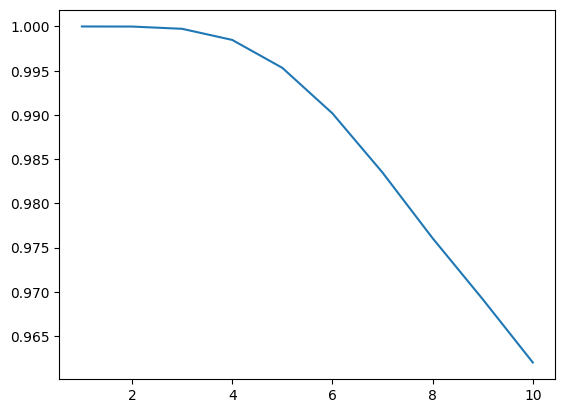

In [7]:
plt.plot(range(1, 11), ssims_lossy)